# 95-891 Homework 3 – Computer Vision
Due March 17th, 2022

In this homework, we will implement [AlexNet](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks)-like deep, convolutional neural network (CNN) with PyTorch. We are going to use the CNN to classify flowers into the 102 categories.

The homework consists of the following parts:

- Load and prepare data.
- Load a pretrained Alexnet in PyTorch.
- Set up transfer learning for flower classification problem
- Train the model
- Model performance monitoring and analysis with learning curve
- Questions regarding the design choices

## The places requiring an input are marked with "???".

#### 1.1. Load the dataset which are in three folders, namely train, validation, and test

In [1]:
import matplotlib.pyplot as plt
from collections import OrderedDict

from copy import deepcopy
import torch
from torch import nn
from torch import optim
from torchvision import datasets, transforms, models

# download the data and unzip it. You should have three sets of data
data_dir = 'final_dataset_1/images'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'


E:\Anaconda\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


#### 1.2. Preview some images
Use PIL library to preview images

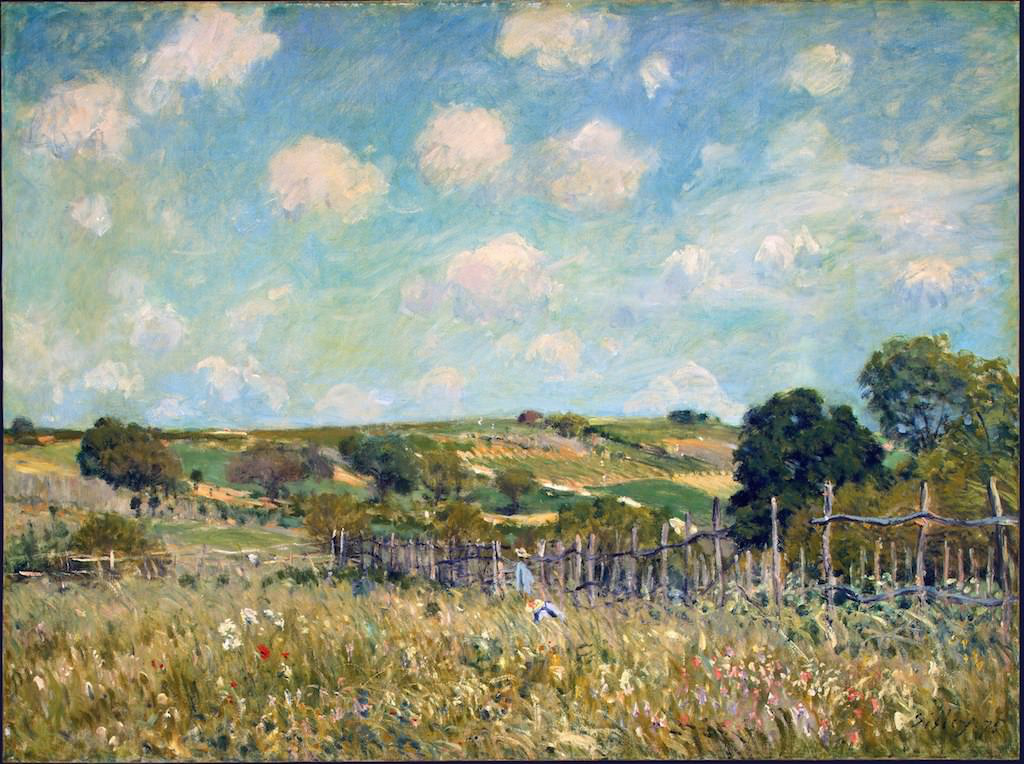

In [3]:
from PIL import Image  #show one example of image

Image.open("final_dataset_1/images/test/Impressionism_images/Alfred_Sisley_66.jpg")

#### 1.3. Data transformation and processing

In [4]:
# Process with some data transformation, do not change
data_transforms = {
    'training': transforms.Compose([transforms.RandomResizedCrop(224),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.RandomRotation(30),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                         [0.229, 0.224,
                                                          0.225])]),

    'validation': transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(
                                          [0.485, 0.456, 0.406],
                                          [0.229, 0.224, 0.225])]),

    'testing': transforms.Compose([transforms.Resize(256),
                                   transforms.CenterCrop(224),
                                   transforms.ToTensor(),
                                   transforms.Normalize([0.485, 0.456, 0.406],
                                                        [0.229, 0.224,
                                                         0.225])])
}
# This decides how many images to process per training/validation
batch_size = 256

image_datasets = {
    'training': datasets.ImageFolder(train_dir,
                                     transform=data_transforms['training']),
    'testing': datasets.ImageFolder(test_dir,
                                    transform=data_transforms['testing']),
    'validation': datasets.ImageFolder(valid_dir,
                                       transform=data_transforms['validation'])
}

dataloaders = {
    'training': torch.utils.data.DataLoader(image_datasets['training'],
                                            batch_size=batch_size,
                                            shuffle=True),
    'testing': torch.utils.data.DataLoader(image_datasets['testing'],
                                           batch_size=batch_size,
                                           shuffle=False),
    'validation': torch.utils.data.DataLoader(image_datasets['validation'],
                                              batch_size=batch_size,
                                              shuffle=True)
}

# get the length of each dataloaders; wit batch size=256, you should have 26 batches of training samples, each with 256 images 
training_len =  len(dataloaders['training'])
test_len =  len(dataloaders['testing'])
validation_len =  len(dataloaders['validation'])
class_to_idx = image_datasets['training'].class_to_idx

print('We have ', training_len, 'batches of training images;', 'each with',
      batch_size, 'images')
print('We have ', validation_len, 'batches of validation images;', 'each with',
      batch_size, 'images')

# Let us preview size of each batch
print('Single batch', next(iter(dataloaders['training']))[0].shape)

We have  11 batches of training images; each with 256 images
We have  2 batches of validation images; each with 256 images
Single batch torch.Size([256, 3, 224, 224])


### *Question 1: What is the effect of random flip and rotation in image data transformation?*
- How does it impact the training?

*Flipping and rotating image can help improve generalization since it can increase variability of data. It also prevents overfitting as it acts as a form of regularization.*

- Why do not we apply them randomly at the validation or test time

*Because validation and test should be original to provide a fair evaluation of the model's performance.*

### *Question 2: Explain the meaning of these numbers for a single batch?*
- 256: batch size, 256 sample per batch.
- 3: RGB color channels.
- 224: height of images in batch.
- 224: width of images in batch.

#### 1.4. Initialize the pretrained model

We are going to use an Alexnet convolutional neural network as our pretrained model. The architecture of the network is shown in 

 https://bouzouitina-hamdi.medium.com/alexnet-imagenet-classification-with-deep-convolutional-neural-networks-d0210289746b

In [5]:
# Transfer learning with alexnet
model = models.alexnet(pretrained=True)

E:\Anaconda\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
E:\Anaconda\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### 1.5. Update the classifier of the model to be compatible with our datasets

In [6]:
# In transfer learning, we freeze the feature parameters from the original model
# The most straightforward way is to freeze their gradient update
# see https://pytorch.org/docs/stable/generated/torch.Tensor.requires_grad.html for how to set it
for param in model.parameters():
    param.requires_grad = False

print(model)

# This is the original classifier with alexnet
print()
print('Original classifier of Alexnet')
print(model.classifier)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [7]:
# now we need to replace the classifier by our datasets
# Note, fc2's out_feature should match our number of classes, which is 102

# Tip: check the original AlexNet classifier for some thoughts; they are similar.

# Defining number of hidden units in our fully connected layer
hidden_units = 4096
number_of_flowers = len(class_to_idx)

# Defining the fully connected layer that will be trained on the flower images
classifier = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(9216, hidden_units)), # this should be a Linear layer; how to connect with the pretrained model?
    ('relu', nn.ReLU()),
    ('dropout', nn.Dropout(0.5)),
    ('fc2', nn.Linear(hidden_units, number_of_flowers)), # what is the output of this layer should be
    ('output', nn.LogSoftmax(dim=1))
]))


### *Question 3: Why are we using the Dropout layer in neural networks as shown above?*
- Explain it is usage briefly.

*Dropout rate is set to be 0.5 in this neural network, which means for each training example, dropout layer randomly sets a fraction of the hidden unit activations to zero, introducing a form of noise and makes the network more robust and less reliant on any single path through the network.*

- How does the dropout layer work during the prediction (evaluation) stage?

*During the prediction stage, the dropout layer is effectively turned off, and its behavior is such that all neurons contribute to the prediction.*

In [8]:
# double check if the classifier of the model is updated.
model.classifier = classifier
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (fc1): Linear(in_features=9216, out_features=4096, bias=True)
    (relu): ReLU()
    (dropout): Drop

### 1.6. Set up the configurations and train it!
- epochs = 30
- since it is a multiclassification problem, we use [negative log likelihood loss](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html)
- we use the [Adam optimizer](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html)
- learning rate (lr) = 0.001

In each epoch, we go through all the training samples to update the model, and evaluate with the validation samples to see how good the current model is.
- accuracy: mean of the matches in predicted class and the labels
- loss: negative log likelihood loss


**Sample outputs are provided below; but yours may vary**
**Your validation accuracy may be better than train; this is fine**

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

epochs = 30
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)
criterion = nn.NLLLoss()  # Negative Log Likelihood Loss for multiclass classification
print_every = 5

validation_accuracies, training_accuracies = [], []
validation_losses, training_losses = [], []

best_validation_accuracy = 0
best_model_weights = None

for e in range(epochs):

    training_loss = training_accuracy = 0
    validation_loss = validation_accuracy = 0

    model.train()
    for batch_idx, (images, labels) in enumerate(dataloaders['training']):

        # Moving images & labels to the GPU if there is one
        images, labels = images.to(device), labels.to(device)

        # Pushing batch through network, calculating loss & gradient, and updating weights
        log_ps = model.forward(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()

        # Calculating metrics
        ps = torch.exp(log_ps)
        top_ps, top_class = ps.topk(1, dim=1)
        matches = (top_class == labels.view(*top_class.shape)).type(
            torch.FloatTensor)
        train_batch_accuracy = matches.mean()

        # Resetting optimizer gradient & tracking metrics
        optimizer.zero_grad()
        training_loss += loss.item()
        train_batch_loss = loss.item()
        training_accuracy += train_batch_accuracy.item()

        if batch_idx % print_every == 0:
            # First analyze the training statistics
            print('epoch', e, 'batch', batch_idx)
            print('training loss per batch', train_batch_loss)
            print('training accuracy per batch', train_batch_accuracy.item())

    # Then do the analysis for the validation only at the end of each training epoch
    model.eval()
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(
                dataloaders['validation']):
            images, labels = images.to(device), labels.to(device)
            log_ps = model(images)
            loss = criterion(log_ps, labels)
            ps = torch.exp(log_ps)
            top_ps, top_class = ps.topk(1, dim=1)
            matches = (top_class == labels.view(*top_class.shape)).type(
                torch.FloatTensor)
            validation_batch_accuracy = matches.mean()

            # Tracking validation metrics
            validation_loss += loss.item()
            validation_batch_loss = loss.item()
            validation_accuracy += validation_batch_accuracy.item()

    # Save the best model weights so far
    if validation_accuracy >= best_validation_accuracy:
        best_validation_accuracy = validation_accuracy
        best_model_weights = model.state_dict()

    # Summary statistic per epoch
    print('epoch', e, 'summary')
    print('avg training loss per epoch', training_loss / training_len)
    print('avg training accuracy per epoch', training_accuracy / training_len)
    training_losses.append(training_loss / training_len)
    training_accuracies.append(training_accuracy / training_len)

    print('avg validation loss per epoch', validation_loss / validation_len)
    print('avg validation accuracy per epoch',
          validation_accuracy / validation_len)
    validation_losses.append(validation_loss / validation_len)
    validation_accuracies.append(validation_accuracy / validation_len)

    print()


epoch 0 batch 0
training loss per batch 1.9371511936187744
training accuracy per batch 0.17578125
epoch 0 batch 5
training loss per batch 10.892099380493164
training accuracy per batch 0.30859375
epoch 0 batch 10
training loss per batch 2.6135902404785156
training accuracy per batch 0.49367088079452515
epoch 0 summary
avg training loss per epoch 13.767308278517289
avg training accuracy per epoch 0.3154757618904114
avg validation loss per epoch 2.3873167037963867
avg validation accuracy per epoch 0.50390625

epoch 1 batch 0
training loss per batch 2.6085870265960693
training accuracy per batch 0.453125
epoch 1 batch 5
training loss per batch 1.248966932296753
training accuracy per batch 0.4921875
epoch 1 batch 10
training loss per batch 1.0963410139083862
training accuracy per batch 0.5569620132446289
epoch 1 summary
avg training loss per epoch 1.6323353268883445
avg training accuracy per epoch 0.4923942739313299
avg validation loss per epoch 0.8972795307636261
avg validation accuracy p

epoch 16 batch 0
training loss per batch 0.6538827419281006
training accuracy per batch 0.74609375
epoch 16 batch 5
training loss per batch 0.6282600164413452
training accuracy per batch 0.80078125
epoch 16 batch 10
training loss per batch 0.5189277529716492
training accuracy per batch 0.7721518874168396
epoch 16 summary
avg training loss per epoch 0.5735172466798262
avg training accuracy per epoch 0.7871700579469855
avg validation loss per epoch 0.5477184951305389
avg validation accuracy per epoch 0.7800164520740509

epoch 17 batch 0
training loss per batch 0.5185073614120483
training accuracy per batch 0.8125
epoch 17 batch 5
training loss per batch 0.5148420333862305
training accuracy per batch 0.7890625
epoch 17 batch 10
training loss per batch 0.3593851625919342
training accuracy per batch 0.8734177350997925
epoch 17 summary
avg training loss per epoch 0.5608306554230776
avg training accuracy per epoch 0.7924697940999811
avg validation loss per epoch 0.5412811636924744
avg validat

### *Question 4: Report the best model's validation accuracy*
best_validation_accuracy = ?

### 1.7. Draw learning curves

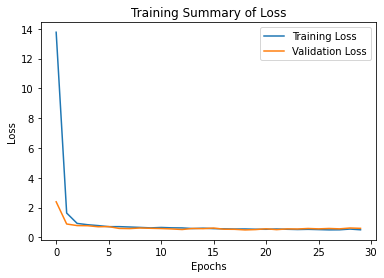

In [10]:
plt.figure()
plt.title("Training Summary of Loss")
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

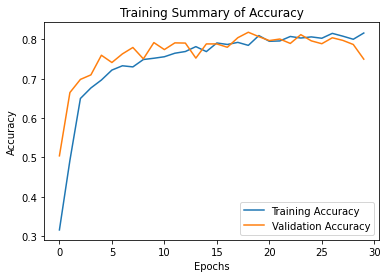

In [11]:
plt.figure()
plt.title("Training Summary of Accuracy")
plt.plot(training_accuracies, label='Training Accuracy')
plt.plot(validation_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### *Question 5: Briefly describe the plots*

### 1.8. Predict on the test data with the best model so far

In [12]:
# Predict on the test data

# Load the best model so far
model.load_state_dict(best_model_weights)
test_accuracy = 0

predictions = []
label_data = []

for images, labels in dataloaders['testing']:
    images, labels = images.to(device), labels.to(device)
    log_ps = model(images)
    loss = criterion(log_ps, labels)
    ps = torch.exp(log_ps)
    top_ps, top_class = ps.topk(1, dim=1)
    matches = (top_class == labels.view(*top_class.shape)).type(
                torch.FloatTensor)
    test_batch_accuracy = matches.mean()

    test_accuracy += test_batch_accuracy.item()
    predictions.extend(top_class.cpu().numpy())
    label_data.extend(labels.cpu().numpy())
    # Try to do similar things as validation to get the test accuracy
    # You also need to store the predictions and labels for all the test data, which will be used later
    # you could save them in predictions and label_data
print('Test Accuracy:', test_accuracy / test_len)

Test Accuracy: 0.8201252222061157


### *Question 6: Report the test accuracy with the best model*

### *Question 7: Provide a confusion matrix between the ground truth and predicted labels in the test dataset. The rows should correspond to the ground ruth categories and the columns to predicted categories. The confusion matrix here should have raw datapoint counts and should not be normalized as percentages*

### *Question 8: Now normalize the raw confusion matrix reported in the previous question by dividing each row by the sum of all its elements. Include this normalized confusion matrix in your report. It may look small but that is fine.*

### *Question 9: What does the diagnal denote in the normalized confusion matrix? What is the meaning of the number in the row 1 column 2?*

confusion matrix
[[91  2  2  2  1  1]
 [ 9 36  0  5  0  0]
 [ 9  0 50  0  0  0]
 [ 8  3  0 38  0  1]
 [ 6  0  0  0  4  1]
 [ 5  0  2  0  0 53]]



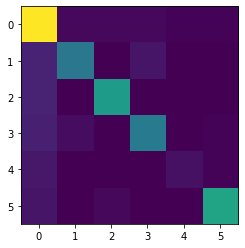

In [13]:
# Please plot the confusion matrix other than print() if possible
from sklearn.metrics import confusion_matrix as conf_mat, ConfusionMatrixDisplay
import numpy as np
cf =conf_mat(label_data,predictions)

print('confusion matrix')
print(cf)
print()
'''disp = ConfusionMatrixDisplay(cf)
disp.plot()
plt.show()'''
plt.imshow(cf)

### *Question 10: Transfer Learning*
- What is the purpose of a pretrained model and why should it work?
- Why should we freeze the features' gradient in the pretrained model but only update the classifier?
- What may happen if we do not freeze the features' gradient?

normalized confusion matrix
[[0.91919192 0.02020202 0.02020202 0.02020202 0.01010101 0.01010101]
 [0.18       0.72       0.         0.1        0.         0.        ]
 [0.15254237 0.         0.84745763 0.         0.         0.        ]
 [0.16       0.06       0.         0.76       0.         0.02      ]
 [0.54545455 0.         0.         0.         0.36363636 0.09090909]
 [0.08333333 0.         0.03333333 0.         0.         0.88333333]]


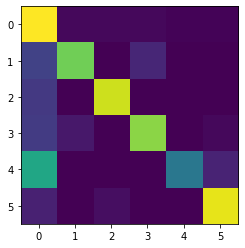

In [14]:
# normalized confusion matrix
print('normalized confusion matrix')
ncf = cf.astype('float') / cf.sum(axis=1)[:, np.newaxis]
print(ncf)
plt.imshow(ncf)